# Week 3–4 Baseline: Bag-of-Words + Logistic Regression
This notebook trains a simple baseline classifier for the Neural Confidence Journal project.

**Pipeline:**
1) Load CSV → 2) Train/Val split (stratified) → 3) TF‑IDF Vectorizer → 4) Logistic Regression → 5) Metrics & Confusion Matrix

**Labels:** 0 = Low, 1 = Neutral, 2 = High

In [ ]:
import pandas as pd
from pathlib import Path


CANDIDATES = [
    Path("../week1-2_dataset/confidence_journal_week1-2.csv"),
    Path("week1-2_dataset/confidence_journal_week1-2.csv"),   
]

for p in CANDIDATES:
    if p.exists():
        CSV_PATH = p
        break
else:
    raise FileNotFoundError(
        "Couldn't find confidence_journal_week1-2.csv. "
        "Expected at ../week1-2_dataset/ or week1-2_dataset/ relative to this notebook."
    )

print("Using CSV at:", CSV_PATH.resolve())
df = pd.read_csv(CSV_PATH)
df.head()


Using CSV at: C:\Users\earne\Downloads\neural-confidence-journal\week1-2_dataset\confidence_journal_week1-2.csv


,text,label
0,I kept rewriting the email because I was worri...,0
1,I froze during the stand‑up and stumbled over ...,0
2,I’m second‑guessing the whole plan; maybe I to...,0
3,I felt small in that conversation and didn’t s...,0
4,I looked at the to‑do list and felt like I’ll ...,0


In [ ]:
# Class distribution check
df['label'].value_counts().sort_index()

label
0    16
1    18
2    16
Name: count, dtype: int64

In [3]:
# Train/validation split (stratified)
from sklearn.model_selection import train_test_split
X = df['text'].astype(str)
y = df['label'].astype(int)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
len(X_train), len(X_val)

(40, 10)

In [4]:
# Vectorize text with TF‑IDF and train Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95)),
    ('lr', LogisticRegression(max_iter=200, multi_class='auto'))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.667     0.667     0.667         3
           1      0.667     0.500     0.571         4
           2      0.250     0.333     0.286         3

    accuracy                          0.500        10
   macro avg      0.528     0.500     0.508        10
weighted avg      0.542     0.500     0.514        10



c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


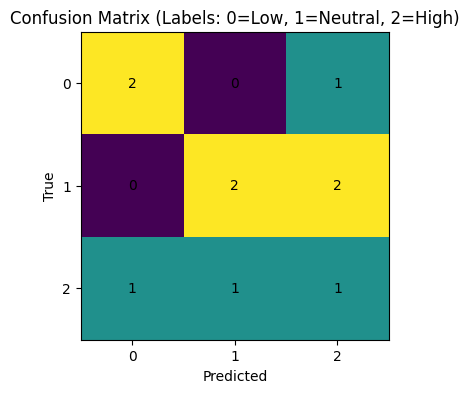

In [ ]:
# Confusion matrix 
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_val, y_pred, labels=[0,1,2])
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm)
ax.set_title('Confusion Matrix (Labels: 0=Low, 1=Neutral, 2=High)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha='center', va='center')
plt.show()

In [ ]:
# Save the trained pipeline for quick reuse
from pathlib import Path
import joblib

out_dir = Path("week3-4_baseline")
out_dir.mkdir(parents=True, exist_ok=True)   

MODEL_PATH = out_dir / "baseline_lr_tfidf.joblib"
joblib.dump(pipe, MODEL_PATH)
print("Saved model to:", MODEL_PATH.resolve())

Saved model to: C:\Users\earne\Downloads\neural-confidence-journal\week3-4_baseline\week3-4_baseline\baseline_lr_tfidf.joblib


In [7]:
# Try a few custom predictions
LABELS = {0: "Low", 1: "Neutral", 2: "High"}

def predict_with_probs(texts, model=pipe):
    probs = model.predict_proba(texts)
    preds = probs.argmax(axis=1)
    rows = []
    for t, p, pr in zip(texts, preds, probs):
        rows.append({
            "text": t,
            "pred": int(p),
            "label": LABELS[int(p)],
            "p(low)": round(pr[0], 3),
            "p(neutral)": round(pr[1], 3),
            "p(high)": round(pr[2], 3),
        })
    return rows

samples = [
    "I froze during my update and wish I could redo it.",
    "I finished what I planned. Tomorrow I will polish the rest.",
    "I nailed that presentation and felt unstoppable."
]

predict_with_probs(samples)

[{'text': 'I froze during my update and wish I could redo it.',
  'pred': 0,
  'label': 'Low',
  'p(low)': np.float64(0.409),
  'p(neutral)': np.float64(0.295),
  'p(high)': np.float64(0.297)},
 {'text': 'I finished what I planned. Tomorrow I will polish the rest.',
  'pred': 1,
  'label': 'Neutral',
  'p(low)': np.float64(0.296),
  'p(neutral)': np.float64(0.412),
  'p(high)': np.float64(0.292)},
 {'text': 'I nailed that presentation and felt unstoppable.',
  'pred': 0,
  'label': 'Low',
  'p(low)': np.float64(0.392),
  'p(neutral)': np.float64(0.288),
  'p(high)': np.float64(0.32)}]

In [ ]:
# Stronger vectorizer + two baselines (NB vs LR)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_df=0.9)

pipelines = {
    "NB": Pipeline([("tfidf", vec), ("nb", MultinomialNB())]),
    "LR_bal": Pipeline([("tfidf", vec), ("lr", LogisticRegression(max_iter=1000, class_weight="balanced"))]),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X, y, cv=skf, scoring="f1_macro")
    print(f"{name} 5-fold macro F1: {scores.mean():.3f} (+/- {scores.std():.3f})")

NB 5-fold macro F1: 0.329 (+/- 0.105)
LR_bal 5-fold macro F1: 0.368 (+/- 0.164)


In [ ]:
# Small grid on Logistic Regression C (fit on train, eval on val)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

pipe = Pipeline([("tfidf", vec), ("lr", LogisticRegression(max_iter=1000, class_weight="balanced"))])

grid = GridSearchCV(
    pipe,
    {"lr__C": [0.5, 1, 2, 4]},
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)

y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred, digits=3))

cm = confusion_matrix(y_val, y_pred, labels=[0,1,2])
cm

Best params: {'lr__C': 0.5}
              precision    recall  f1-score   support

           0      0.500     0.333     0.400         3
           1      0.500     0.750     0.600         4
           2      0.000     0.000     0.000         3

    accuracy                          0.400        10
   macro avg      0.333     0.361     0.333        10
weighted avg      0.350     0.400     0.360        10



array([[1, 1, 1],
       [0, 3, 1],
       [1, 2, 0]])

In [ ]:
# Probabilities on sample sentences 
import numpy as np, pandas as pd

LABELS = {0:"Low", 1:"Neutral", 2:"High"}

def predict_table(texts, model):
    P = model.predict_proba(texts); y = P.argmax(1)
    rows = []
    for t,p,pr in zip(texts, y, P):
        rows.append({
            "text": t,
            "pred": int(p),
            "label": LABELS[int(p)],
            "p(low)": round(pr[0],3),
            "p(neutral)": round(pr[1],3),
            "p(high)": round(pr[2],3),
        })
    return pd.DataFrame(rows)

samples = [
    "I froze during my update and wish I could redo it.",
    "I finished what I planned. Tomorrow I will polish the rest.",
    "I nailed that presentation and felt unstoppable."
]

predict_table(samples, best_model)

,text,pred,label,p(low),p(neutral),p(high)
0,I froze during my update and wish I could redo...,0,Low,0.380,0.311,0.309
1,I finished what I planned. Tomorrow I will pol...,1,Neutral,0.307,0.396,0.297
2,I nailed that presentation and felt unstoppable.,0,Low,0.390,0.280,0.329


              precision    recall  f1-score   support

           0      0.500     0.333     0.400         3
           1      0.500     0.750     0.600         4
           2      0.000     0.000     0.000         3

    accuracy                          0.400        10
   macro avg      0.333     0.361     0.333        10
weighted avg      0.350     0.400     0.360        10

Saved to: C:\Users\earne\Downloads\neural-confidence-journal\week3-4_baseline\week3-4_baseline


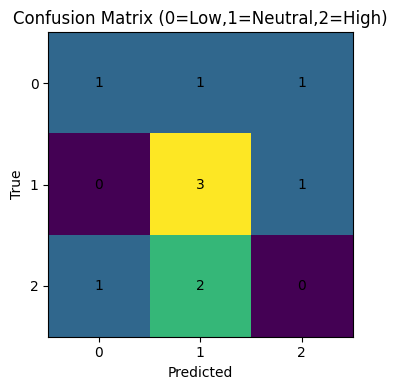

In [ ]:
# Save the best model + artifacts into week3-4_baseline/
from pathlib import Path
import joblib
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

out = Path("week3-4_baseline")
out.mkdir(parents=True, exist_ok=True)

# Save model
joblib.dump(best_model, out / "best_model.joblib")

# Save text report
report_txt = classification_report(y_val, y_pred, digits=3)
(out / "classification_report.txt").write_text(report_txt, encoding="utf-8")
print(report_txt)

# Save confusion matrix figure
cm = confusion_matrix(y_val, y_pred, labels=[0,1,2])
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm)
ax.set_title('Confusion Matrix (0=Low,1=Neutral,2=High)')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
for (i,j),v in np.ndenumerate(cm): 
    ax.text(j,i,int(v),ha="center",va="center")
fig.tight_layout()
fig.savefig(out / "confusion_matrix.png", dpi=150)
print("Saved to:", out.resolve())